<img src="Photo/ML Picture.jpg" width="500"  height="200" align=center>


# Mobile Legends Comment Analysis Project


## Approach

### 1. Data Collection and Preprocessing

As part of the Data Team at Mobile Legends Company, your first task is to gather the comment reviews from the Google Play Store. These comments are a valuable resource that will provide insights into players' experiences and opinions.

1. **Data Gathering:** Obtain the scraped comment reviews dataset from the Google Play Store. This dataset will contain a multitude of comments left by players of Mobile Legends.

2. **Data Cleaning:** Clean the dataset by removing duplicate comments, irrelevant entries, and any sensitive information that might be present. This ensures that your analysis is based on reliable and relevant data.

3. **Text Preprocessing:** Tokenize the text of each comment, converting it into individual words or phrases. Remove stopwords, special characters, and perform stemming or lemmatization to standardize the text.


In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to C:\Users\Tien
[nltk_data]     Tien\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Tien
[nltk_data]     Tien\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Tien
[nltk_data]     Tien\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Overview
df = pd.read_csv('MLreviewsRAW.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,19f19a90-f6af-4bcf-8807-37d96edbcd7a,prince adam,https://play-lh.googleusercontent.com/a/AGNmyx...,NaN,1,0,1.5.64.6161,2023-02-28 14:55:48,NaN,NaN
1,b7cb76e8-3737-4a16-906b-9350b3fe228f,sayz ideas,https://play-lh.googleusercontent.com/a-/ACB-R...,unbalanced,1,0,NaN,2023-02-28 14:55:23,NaN,NaN
2,c73ace77-f38e-42b9-aa5f-78c61c5561cf,ling ling,https://play-lh.googleusercontent.com/a/AGNmyx...,loved,5,0,1.7.44.8111,2023-02-28 14:55:20,NaN,NaN
3,d7f0628c-7b26-4cfa-b3bd-d293911b9fc5,jorniel juntilla,https://play-lh.googleusercontent.com/a/AGNmyx...,matchmaking rigged give epic hayabusa skin con...,1,0,NaN,2023-02-28 14:54:59,NaN,NaN
4,97ab3d82-bd4f-4788-b66b-58c553199ecc,amirun afiq,https://play-lh.googleusercontent.com/a-/ACB-R...,nice game,5,0,1.7.58.8261,2023-02-28 14:53:51,NaN,NaN


In [3]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1169921 entries, 0 to 1169920
Data columns (total 10 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   reviewId              1169921 non-null  object
 1   userName              1161250 non-null  object
 2   userImage             1169921 non-null  object
 3   content               1140083 non-null  object
 4   score                 1169921 non-null  int64 
 5   thumbsUpCount         1169921 non-null  int64 
 6   reviewCreatedVersion  845038 non-null   object
 7   at                    1169921 non-null  object
 8   replyContent          1667 non-null     object
 9   repliedAt             1667 non-null     object
dtypes: int64(2), object(8)
memory usage: 89.3+ MB


This visual shows the distribution of null vs non-null values for some columns in a dataset. It indicates how many rows in the dataset have missing or present values for each column. 
- The data set has 10 columns: “reviewid”, “userName”, “userImage”, “content”, “score”, “thumbsUpCount”, “reviewVersion”, “createdAt”, “replyContent”, and “repliedAt”.
- The data set has a total of about 1.1 million rows.
- “replyContent”, and “repliedAt” have no data in it 

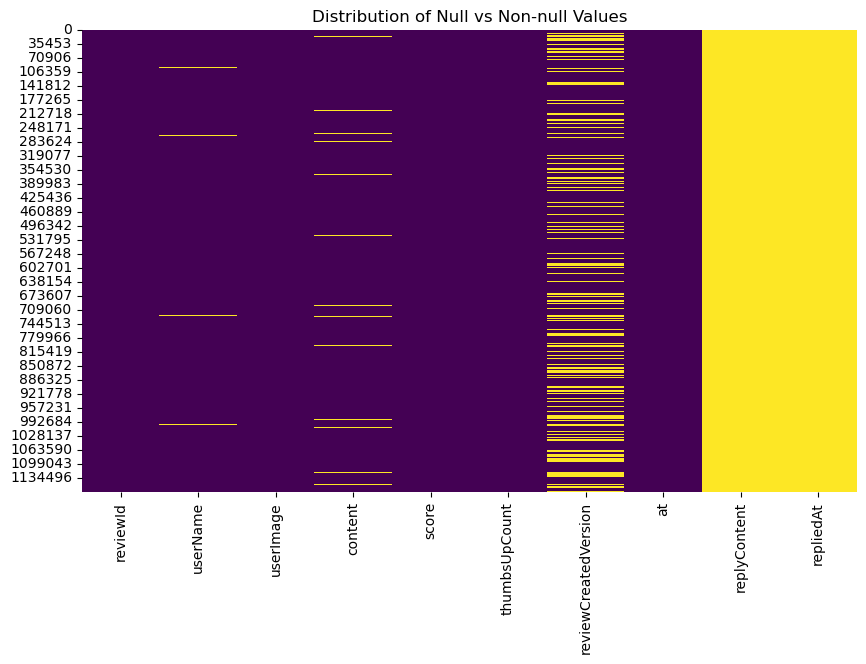

In [4]:
# Missing values visualization
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title('Distribution of Null vs Non-null Values')
plt.show()

In [5]:
# Impute missing values
df['userName'].fillna('Unknown', inplace=True)
df['content_missing'] = df['content'].isnull()
df['version_missing'] = df['reviewCreatedVersion'].isnull()

In [6]:
# Droping unecessary columns
columns_to_drop = ['replyContent', 'repliedAt']
df.drop(columns=columns_to_drop, inplace=True)

In [7]:
# Data Transformation
df['at'] = pd.to_datetime(df['at'])

In [8]:
# Identify duplicate entries
duplicate_rows = df[df.duplicated(subset=['reviewId'], keep=False)]
duplicate_rows

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,content_missing,version_missing


In [9]:
# Remove duplicates
# df.drop_duplicates(subset=['reviewId'], keep='first', inplace=True)

In [10]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [token for token in tokens if token.isalnum()]  # Remove special characters
    tokens = [token for token in tokens if token not in stopwords.words('english')]  # Remove stopwords
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]  # Apply stemming
    return ' '.join(tokens)

In [11]:
# Apply preprocessing using vectorized operations and handle missing content
df['content_preprocessed'] = np.where(df['content_missing'], '', np.vectorize(preprocess_text)(df['content'].fillna('')))

In [12]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,content_missing,version_missing,content_preprocessed
0,19f19a90-f6af-4bcf-8807-37d96edbcd7a,prince adam,https://play-lh.googleusercontent.com/a/AGNmyx...,NaN,1,0,1.5.64.6161,2023-02-28 14:55:48,True,False,
1,b7cb76e8-3737-4a16-906b-9350b3fe228f,sayz ideas,https://play-lh.googleusercontent.com/a-/ACB-R...,unbalanced,1,0,NaN,2023-02-28 14:55:23,False,True,unbalanc
2,c73ace77-f38e-42b9-aa5f-78c61c5561cf,ling ling,https://play-lh.googleusercontent.com/a/AGNmyx...,loved,5,0,1.7.44.8111,2023-02-28 14:55:20,False,False,love
3,d7f0628c-7b26-4cfa-b3bd-d293911b9fc5,jorniel juntilla,https://play-lh.googleusercontent.com/a/AGNmyx...,matchmaking rigged give epic hayabusa skin con...,1,0,NaN,2023-02-28 14:54:59,False,True,matchmak rig give epic hayabusa skin consid gi...
4,97ab3d82-bd4f-4788-b66b-58c553199ecc,amirun afiq,https://play-lh.googleusercontent.com/a-/ACB-R...,nice game,5,0,1.7.58.8261,2023-02-28 14:53:51,False,False,nice game


### 2. Exploratory Data Analysis (EDA)

With your cleaned and preprocessed dataset, it's time to dive into the data and uncover initial insights about player sentiments and preferences.

1. **Basic Statistics:** Calculate basic statistics such as the number of comments, average per score, and more. These statistics provide a snapshot of the dataset's characteristics.

2. **Visualizations:** Create visualizations like histograms, bar charts, and word clouds to understand the distribution of sentiments and frequently mentioned terms. This step sets the stage for deeper analysis.


In [13]:
# Summary Statistics
df.describe()

,score,thumbsUpCount
count,1.169921e+06,1.169921e+06
mean,3.284836e+00,1.653737e+00
std,1.879604e+00,7.911518e+01
min,1.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00
50%,5.000000e+00,0.000000e+00
75%,5.000000e+00,0.000000e+00
max,5.000000e+00,4.522800e+04


In [14]:
# Summary Statistics
df['score'].value_counts()

5    594763
1    438947
4     57452
3     42911
2     35848
Name: score, dtype: int64

This visual shows the distribution of scores for some data set. It indicates how many times each score from 1 to 5 occurred in the data. 
- The most common score is 5, which occurred about 600,000 times. This means that most of the data points have a high score.
- The second most common score is 1, which occurred about 400,000 times. This means that there is also a significant number of data points with a low score.
- The scores of 2, 3, and 4 are much less frequent, each occurring about 100,000 times or less. This means that there are few data points with moderate scores.
- The distribution of scores is skewed to the left, meaning that there are more high scores than low scores. This suggests that the data set has a positive outlook or quality.

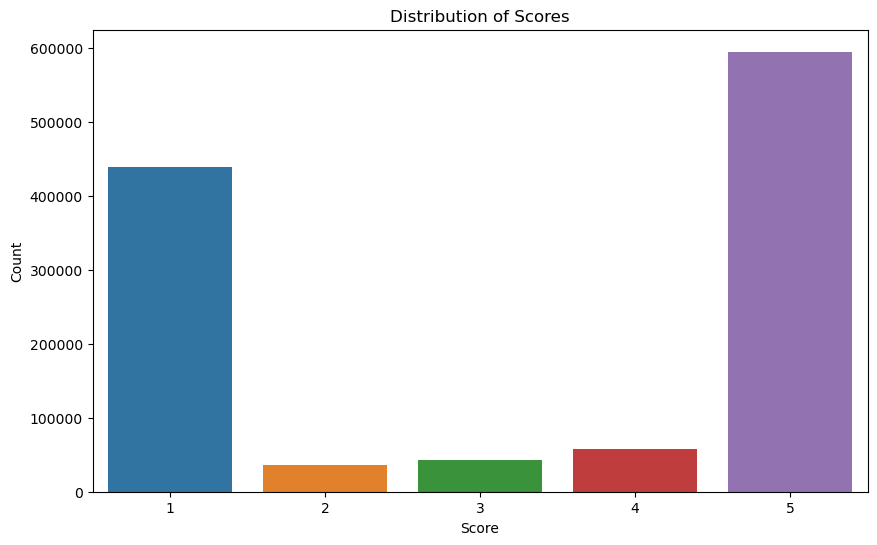

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='score')
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.show()

This scatter plot helps us understand the relationship between user scores and the number of thumbs-up they received. If there's a positive correlation, higher scores should be associated with more thumbs-ups.
- There is a clear trend that as the score increases, the thumbs up count decrease.
- The graph shows that there are outliers in score 1 and score 4

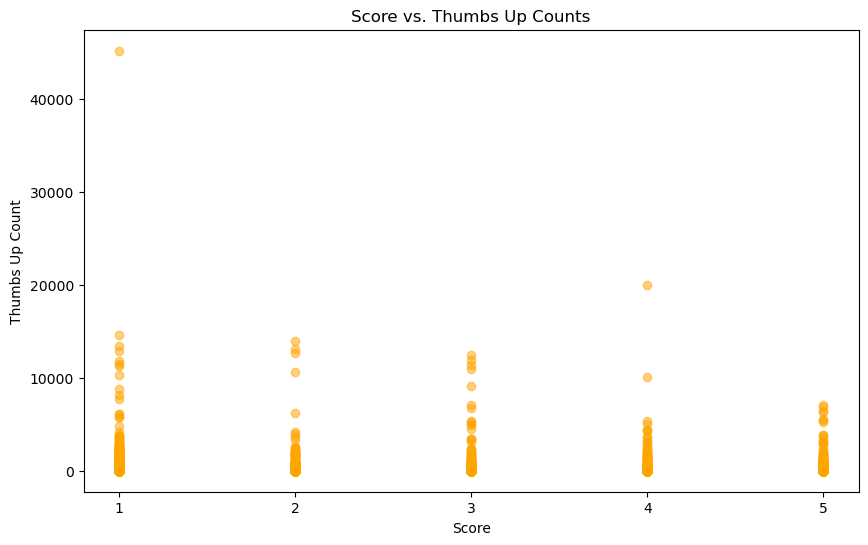

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(df['score'], df['thumbsUpCount'], color='orange', alpha=0.5)
plt.xticks(range(1,6))
plt.xlabel('Score')
plt.ylabel('Thumbs Up Count')
plt.title('Score vs. Thumbs Up Counts')
plt.show()

_The graph shows that as the score increases from 1 to 5, the average thumbs up count decreases from approximately 4 to approximately 1_

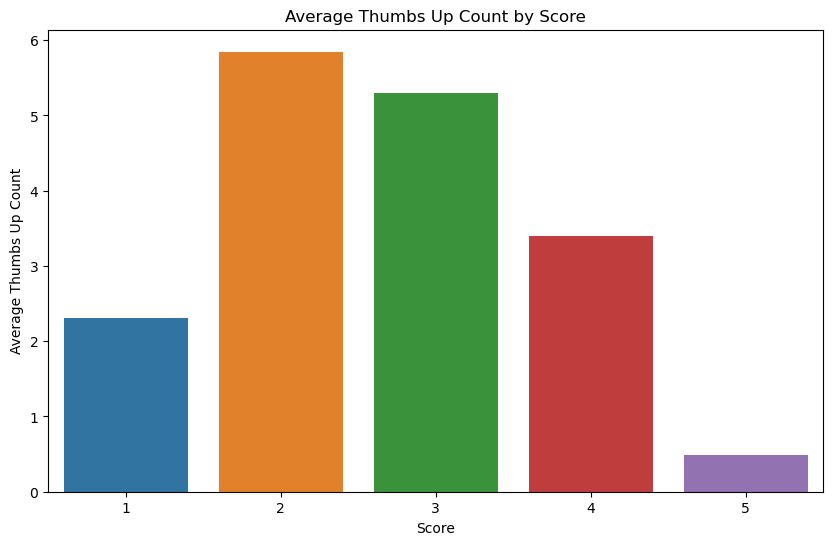

In [17]:
# Average Thumbs Up Count by Score
average_thumbs_up = df.groupby('score')['thumbsUpCount'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=average_thumbs_up.index, y=average_thumbs_up.values)
plt.xlabel('Score')
plt.ylabel('Average Thumbs Up Count')
plt.title('Average Thumbs Up Count by Score')
plt.show()

_The spike in Jan 2022 reaches approximately 120000 review counts._

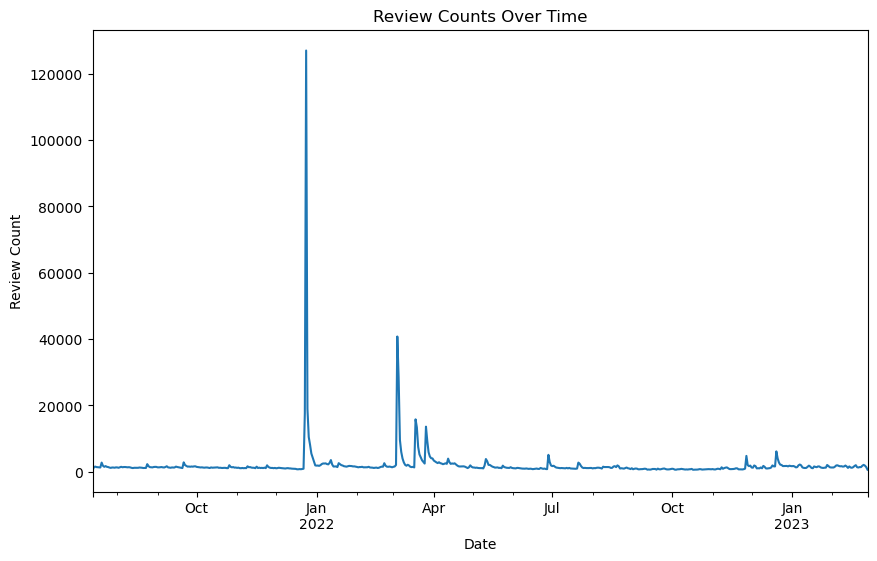

In [18]:
plt.figure(figsize=(10, 6))
df.resample('D', on='at')['reviewId'].count().plot()
plt.xlabel('Date')
plt.ylabel('Review Count')
plt.title('Review Counts Over Time')
plt.show()

_good game as the most frequent word_

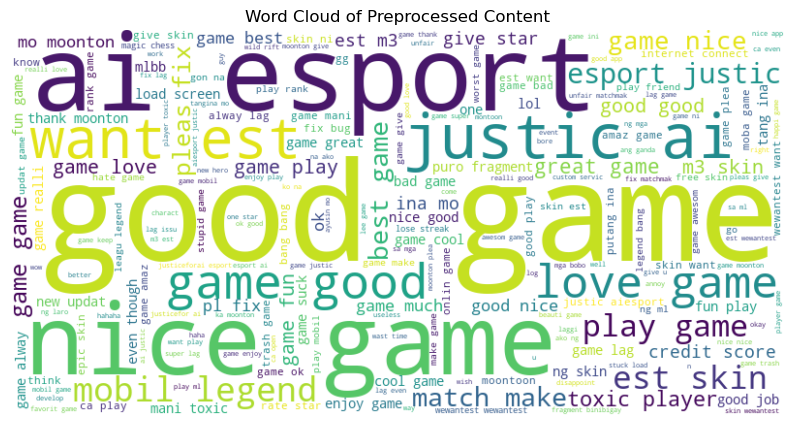

In [19]:
# Combine all preprocessed content into a single string
all_text = ' '.join(df['content_preprocessed'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Preprocessed Content')
plt.show()

### 3. Sentiment Analysis and Topic Modeling

Now, it's time to unravel the sentiments expressed by players and identify the recurring topics that drive their conversations.

1. **Sentiment Analysis:** Utilize pre-trained sentiment analysis models to categorize comments as positive, negative, or neutral. This analysis will give you an overview of player sentiments.

2. **Topic Modeling:** Apply techniques like Latent Dirichlet Allocation (LDA) to uncover underlying topics within the comments. By grouping similar comments together, you'll identify key themes players are discussing.


In [20]:
df['sentiment_scores'] = df['content_preprocessed'].apply(lambda x: sia.polarity_scores(x))
df['sentiment'] = df['sentiment_scores'].apply(lambda x: 'positive' if x['compound'] >= 0.05 else ('negative' if x['compound'] <= -0.05 else 'neutral'))

In [21]:
neutral_comments = df[df['sentiment'] == 'neutral']['content_preprocessed'].tolist()
positive_comments = df[df['sentiment'] == 'positive']['content_preprocessed'].tolist()
negative_comments = df[df['sentiment'] == 'negative']['content_preprocessed'].tolist()

In [22]:
# Tokenization and Word Frequency
neutral_tokens = ' '.join(neutral_comments).split()
positive_tokens = ' '.join(positive_comments).split()
negative_tokens = ' '.join(negative_comments).split()

In [23]:
neutral_word_counts = Counter(neutral_tokens)
positive_word_counts = Counter(positive_tokens)
negative_word_counts = Counter(negative_tokens)

## Sentiment Analysis

### Sentiment Distribution


The majority of the Google Play comment reviews have either a neutral or positive sentiment, with a smaller proportion of negative sentiment.

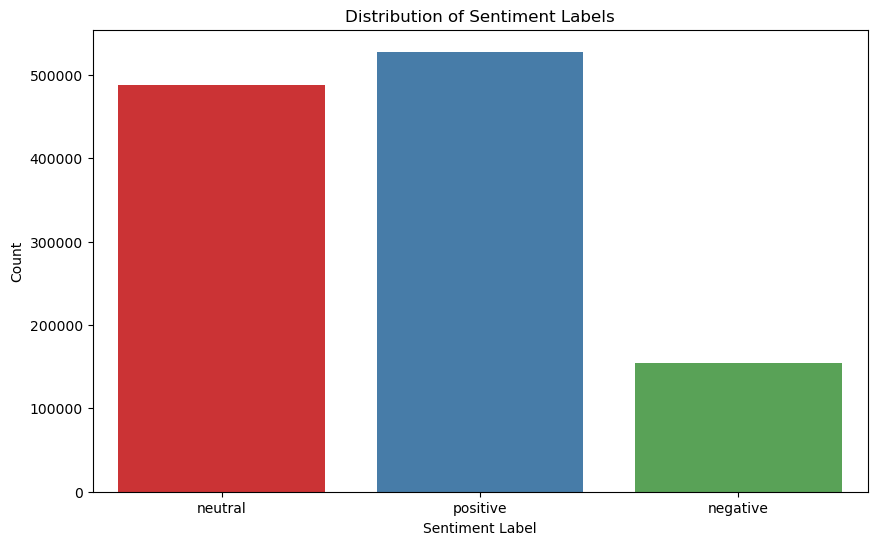

In [24]:
# Plot the distribution of sentiment labels
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df, palette='Set1')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

In [25]:
def plot_word_frequencies(word_counts, title):
    most_common = word_counts.most_common(10)
    words, counts = zip(*most_common)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(words), y=list(counts), palette='viridis')  # Convert words and counts to lists
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

### Most common words in each sentiment category

#### Neutral

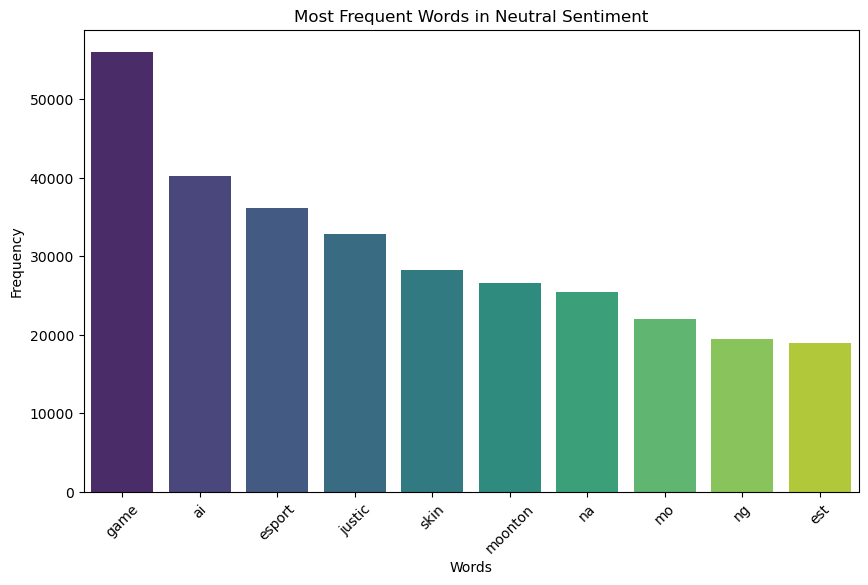

In [26]:
plot_word_frequencies(neutral_word_counts, 'Most Frequent Words in Neutral Sentiment')

#### Positive

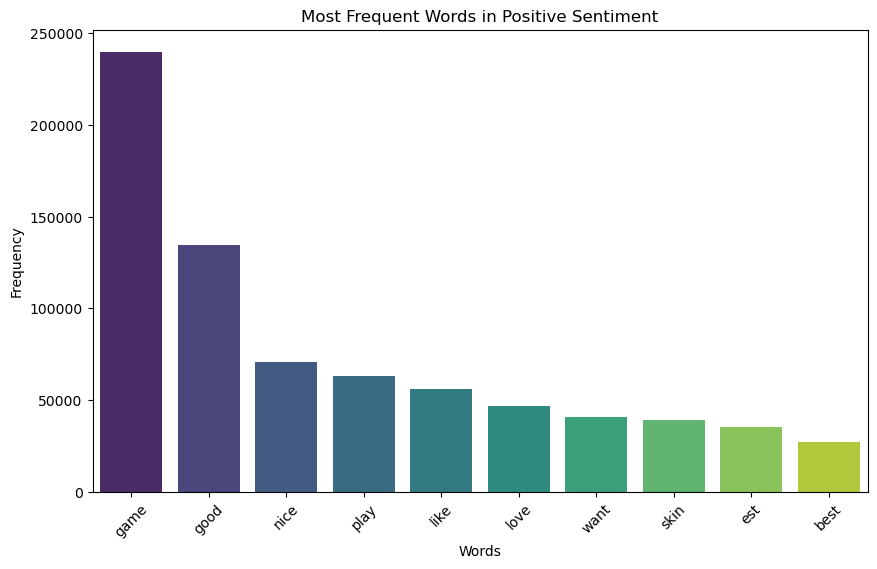

In [27]:
plot_word_frequencies(positive_word_counts, 'Most Frequent Words in Positive Sentiment')

#### Negative

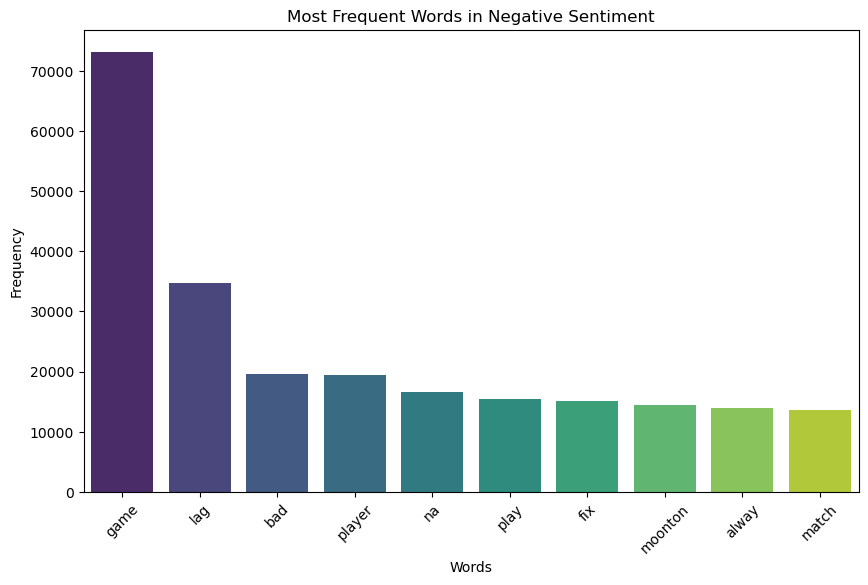

In [28]:
plot_word_frequencies(negative_word_counts, 'Most Frequent Words in Negative Sentiment')

_Words appearing in both positive and negative comments_

In [29]:
mixed_sentiment_words = [word for word in positive_word_counts if word in negative_word_counts][:10]
print("Top 10 Words Appearing in both Positive and Negative Sentiments:", mixed_sentiment_words)

Top 10 Words Appearing in both Positive and Negative Sentiments: ['love', 'nice', 'game', 'need', 'make', 'event', 'mlbb', 'x', 'one', 'piec']


### Sentiment movement

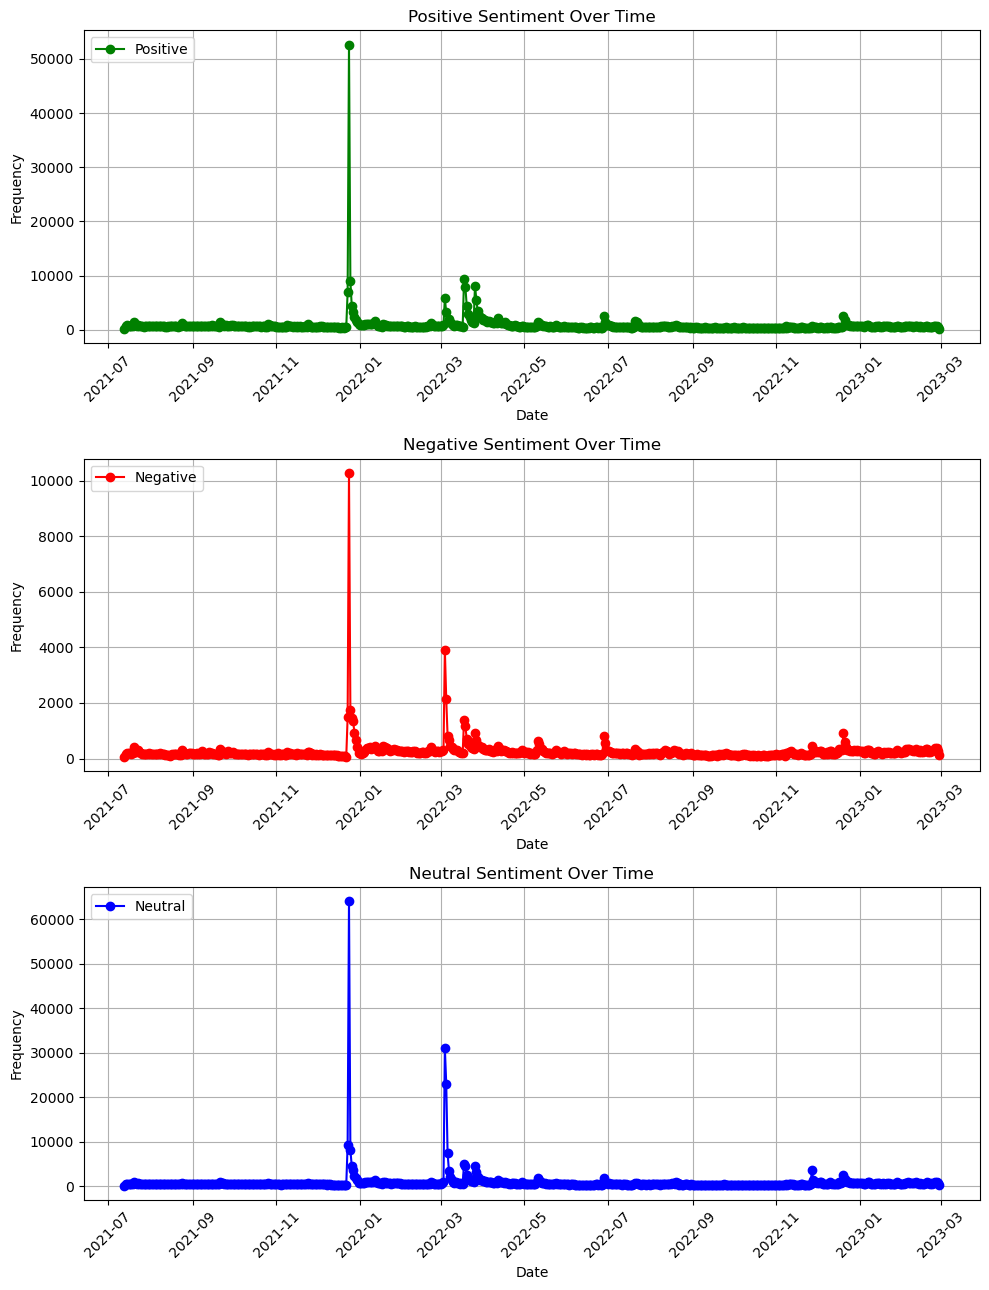

In [30]:
# Count the frequency of each sentiment by date
sentiment_counts = df.groupby([df['at'].dt.date, 'sentiment']).size().unstack().fillna(0)

# Create three separate plots for sentiment distribution over time
fig, axs = plt.subplots(3, 1, figsize=(10, 13))  # 3 rows, 1 column

# Plot positive sentiment distribution over time
axs[0].plot(sentiment_counts.index, sentiment_counts['positive'], marker='o', label='Positive', color='green')
axs[0].set_title('Positive Sentiment Over Time')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Frequency')
axs[0].legend(loc='upper left')
axs[0].grid(True)
axs[0].tick_params(axis='x', rotation=45)

# Plot negative sentiment distribution over time
axs[1].plot(sentiment_counts.index, sentiment_counts['negative'], marker='o', label='Negative', color='red')
axs[1].set_title('Negative Sentiment Over Time')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Frequency')
axs[1].legend(loc='upper left')
axs[1].grid(True)
axs[1].tick_params(axis='x', rotation=45)

# Plot neutral sentiment distribution over time
axs[2].plot(sentiment_counts.index, sentiment_counts['neutral'], marker='o', label='Neutral', color='blue')
axs[2].set_title('Neutral Sentiment Over Time')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Frequency')
axs[2].legend(loc='upper left')
axs[2].grid(True)
axs[2].tick_params(axis='x', rotation=45)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### Digging deeper
It seems that the version 1.6.58.7191 has a lot of update changes in the game

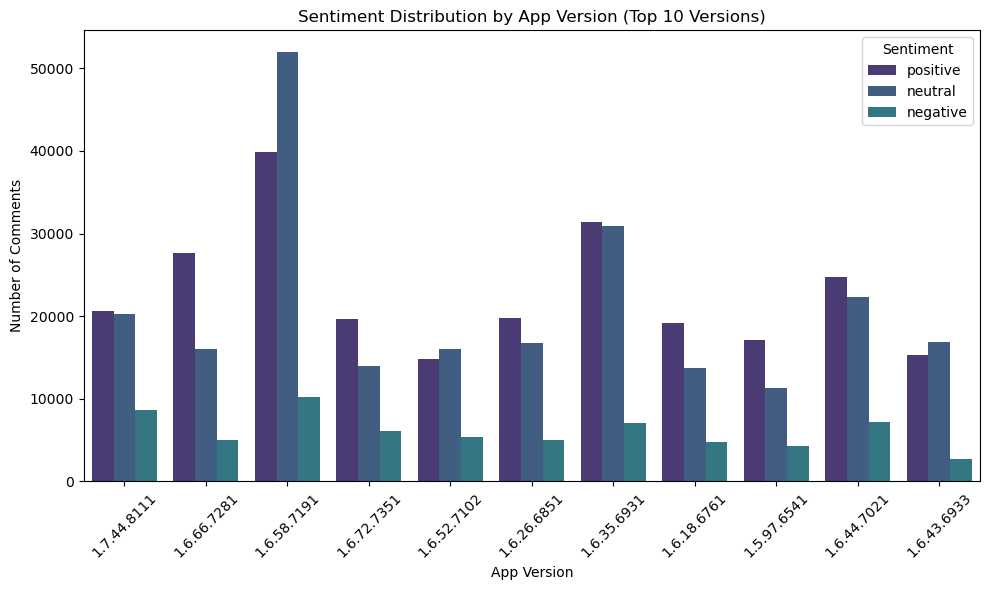

In [31]:
# Get the top 10 versions for each sentiment
top_versions_positive = df[df['sentiment'] == 'positive']['reviewCreatedVersion'].value_counts().head(10)
top_versions_negative = df[df['sentiment'] == 'negative']['reviewCreatedVersion'].value_counts().head(10)
top_versions_neutral = df[df['sentiment'] == 'neutral']['reviewCreatedVersion'].value_counts().head(10)

# Combine the top versions for all sentiments
top_versions = pd.concat([top_versions_positive, top_versions_negative, top_versions_neutral]).index.unique()

# Filter the DataFrame to include only the top versions
df_top_versions = df[df['reviewCreatedVersion'].isin(top_versions)]

# Visualize sentiment distribution by app version for the top versions
sns.set_palette("viridis")
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_versions, x='reviewCreatedVersion', hue='sentiment')
plt.title('Sentiment Distribution by App Version (Top 10 Versions)')
plt.xlabel('App Version')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

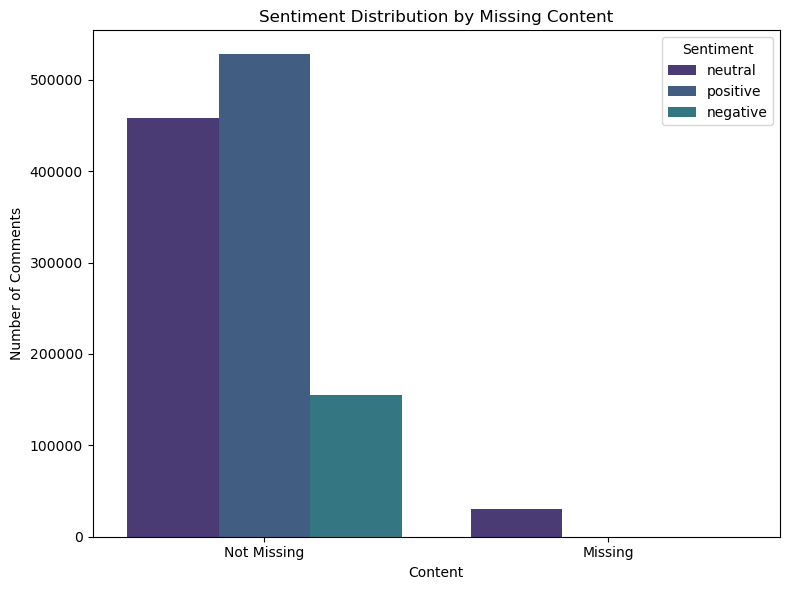

In [53]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='content_missing', hue='sentiment')
plt.title('Sentiment Distribution by Missing Content')
plt.xlabel('Content')
plt.ylabel('Number of Comments')
plt.legend(title='Sentiment')
plt.xticks(ticks=[0, 1], labels=['Not Missing', 'Missing'])
plt.tight_layout()
plt.show()

## Topic Modeling

In [34]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['content_preprocessed'])

In [37]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

In [38]:
df['topics'] = lda.transform(X).argmax(axis=1)

In [46]:
# Print topics and their top words
feature_names = vectorizer.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: game, like, lag, play, fix, updat, wewantest, great, app, cool
Topic 1: game, play, player, make, fun, match, hero, thank, pleas, skin
Topic 2: game, good, nice, ai, esport, justic, best, love, amaz, lee
Topic 3: est, skin, want, ok, love, mobil, legend, m3, game, awesom
Topic 4: na, ng, mo, sa, ko, moonton, ang, ka, ml, ako


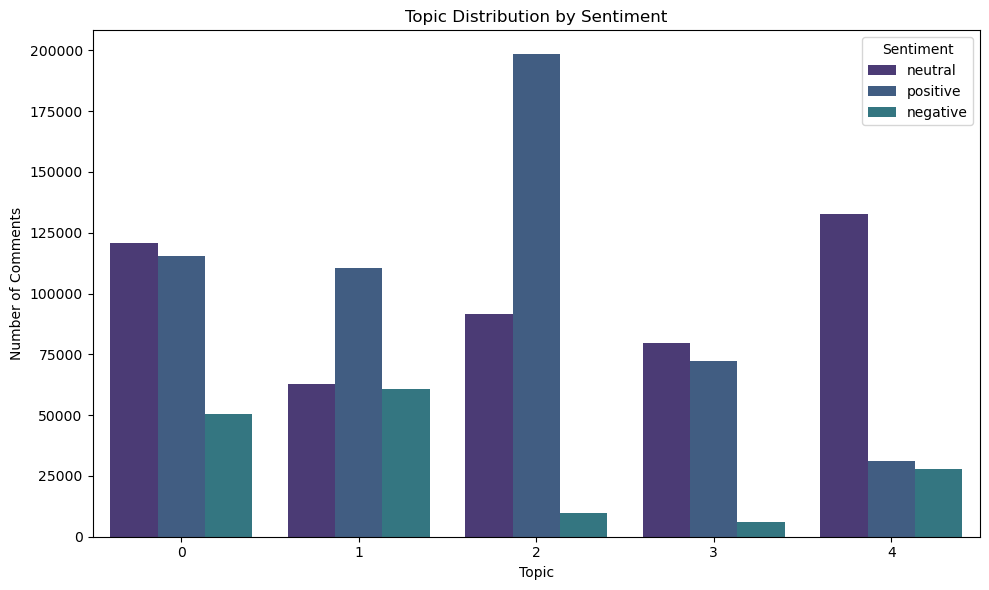

In [41]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='topics', hue='sentiment')
plt.title('Topic Distribution by Sentiment')
plt.xlabel('Topic')
plt.ylabel('Number of Comments')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

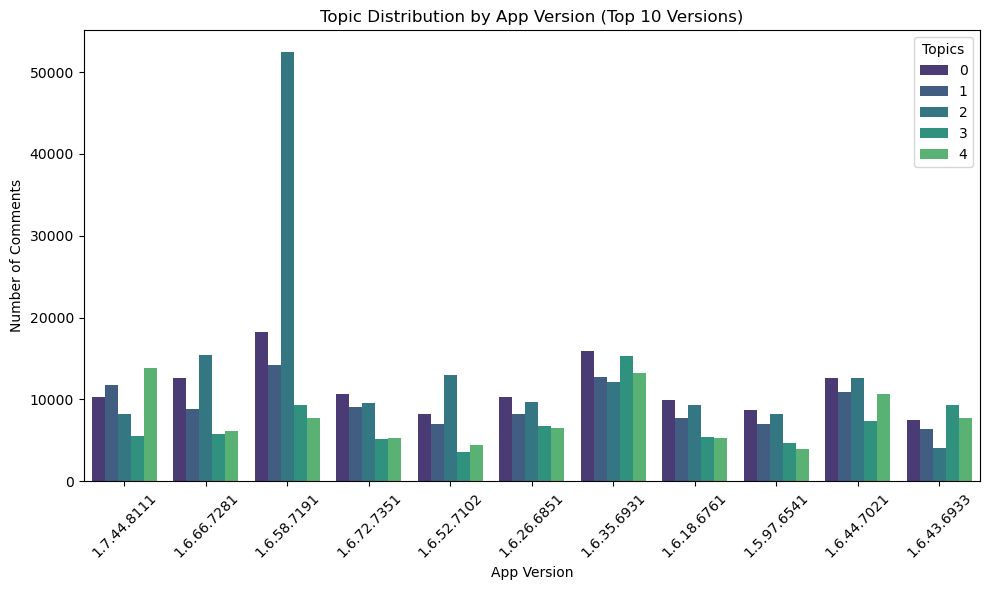

In [49]:
# Get the top 10 versions for each sentiment
top_versions_positive = df[df['sentiment'] == 'positive']['reviewCreatedVersion'].value_counts().head(10).index
top_versions_negative = df[df['sentiment'] == 'negative']['reviewCreatedVersion'].value_counts().head(10).index
top_versions_neutral = df[df['sentiment'] == 'neutral']['reviewCreatedVersion'].value_counts().head(10).index

# Combine all top versions
top_versions = set(top_versions_positive) | set(top_versions_negative) | set(top_versions_neutral)

# Filter the DataFrame to include only the top versions
df_top_versions = df[df['reviewCreatedVersion'].isin(top_versions)]

# Visualize sentiment distribution by app version for the top versions
sns.set_palette("viridis")
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_versions, x='reviewCreatedVersion', hue='topics')
plt.title('Topic Distribution by App Version (Top 10 Versions)')
plt.xlabel('App Version')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.legend(title='Topics')
plt.tight_layout()
plt.show()

### 4. Statistical Analysis and Visualization

With sentiments and topics identified, it's time to dive deeper into the data and draw meaningful conclusions.

1. **Correlation Analysis:** Perform statistical tests to determine if there are correlations between sentiment and specific game features. For instance, does positive sentiment correlate with favorable comments about gameplay mechanics?

2. **Visual Representation:** Create visualizations, such as scatter plots or heatmaps, to showcase your findings from the correlation analysis. Clear visuals help convey complex relationships effectively.


In [65]:
# Filter data for comments mentioning "character balance"
df_lag = df[df['content_preprocessed'].str.contains('lag', case=False, na=False)]

# Filter for sentiment and topic columns
df_lag = df_character_balance[['sentiment', 'topics']]

In [66]:
# Calculate sentiment proportions
sentiment_proportions = df_lag['sentiment'].value_counts(normalize=True)

# Print sentiment proportions
print(sentiment_proportions)

negative    0.532173
positive    0.260607
neutral     0.207220
Name: sentiment, dtype: float64


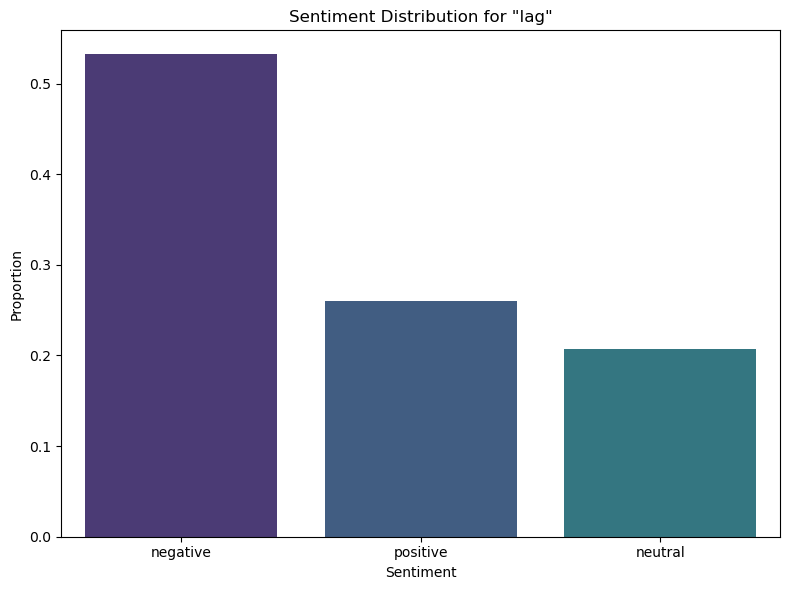

In [67]:
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_proportions.index, y=sentiment_proportions.values)
plt.title('Sentiment Distribution for "lag"')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.tight_layout()
plt.show()

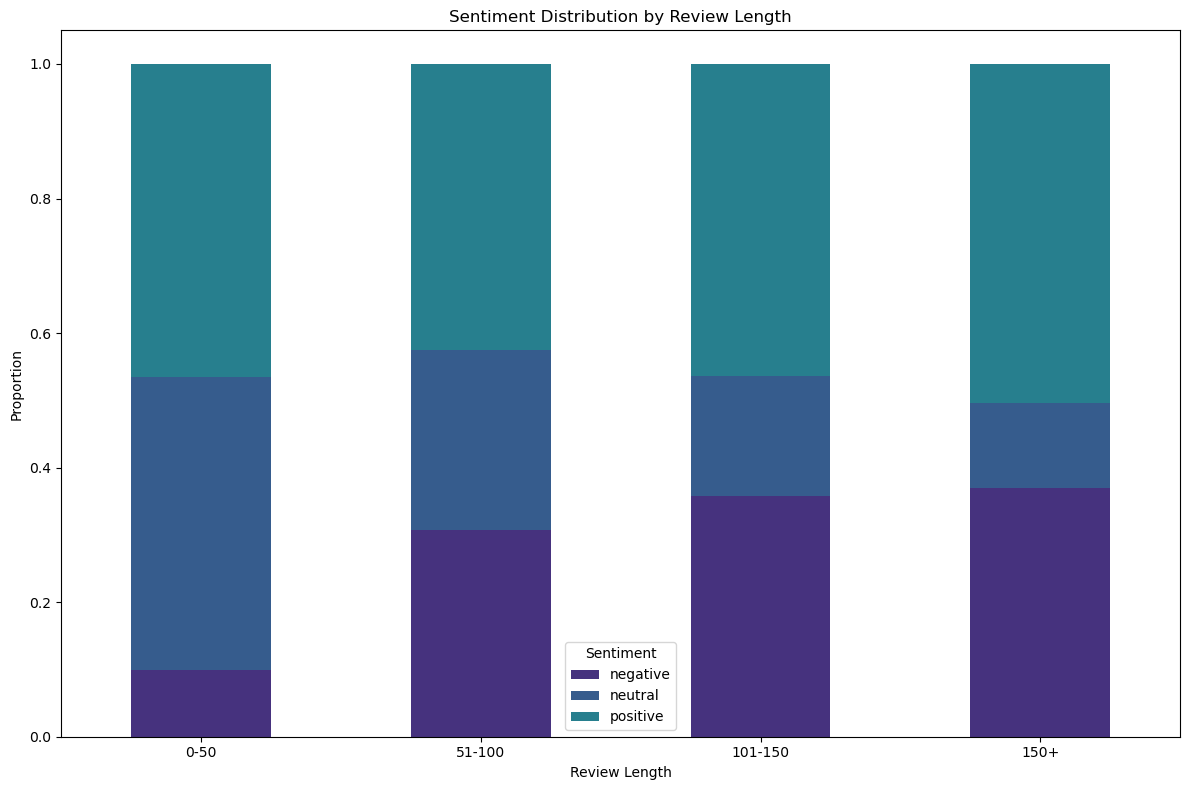

In [72]:
# Calculate review length
df['review_length'] = df['content_preprocessed'].apply(len)

# Create bins for review length
bins = [0, 50, 100, 150, np.inf]
labels = ['0-50', '51-100', '101-150', '150+']
df['review_length_bin'] = pd.cut(df['review_length'], bins=bins, labels=labels)

# Calculate sentiment proportions by review length
sentiment_by_length = df.groupby(['review_length_bin', 'sentiment'])['reviewId'].count().unstack()
sentiment_by_length = sentiment_by_length.div(sentiment_by_length.sum(axis=1), axis=0)

# Plot sentiment by review length
sentiment_by_length.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Sentiment Distribution by Review Length')
plt.xlabel('Review Length')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

A correlation coefficient of 0.40 indicates a moderate positive correlation between sentiment and the "score" feature.
As sentiment becomes more positive, the "score" tends to increase, and as sentiment becomes more negative, the "score" tends to decrease. However, the correlation is not very strong, suggesting that while there's a relationship, other factors also influence the "score."
Correlation between Sentiment and Thumbs Up Count: -0.00

A correlation coefficient close to 0 indicates little to no linear correlation between sentiment and the "thumbsUpCount" feature.
This means that changes in sentiment are not associated with changes in the "thumbsUpCount." The negative sign indicates that there might be a slight tendency for more negative sentiments to have slightly higher "thumbsUpCount," but the relationship is very weak.

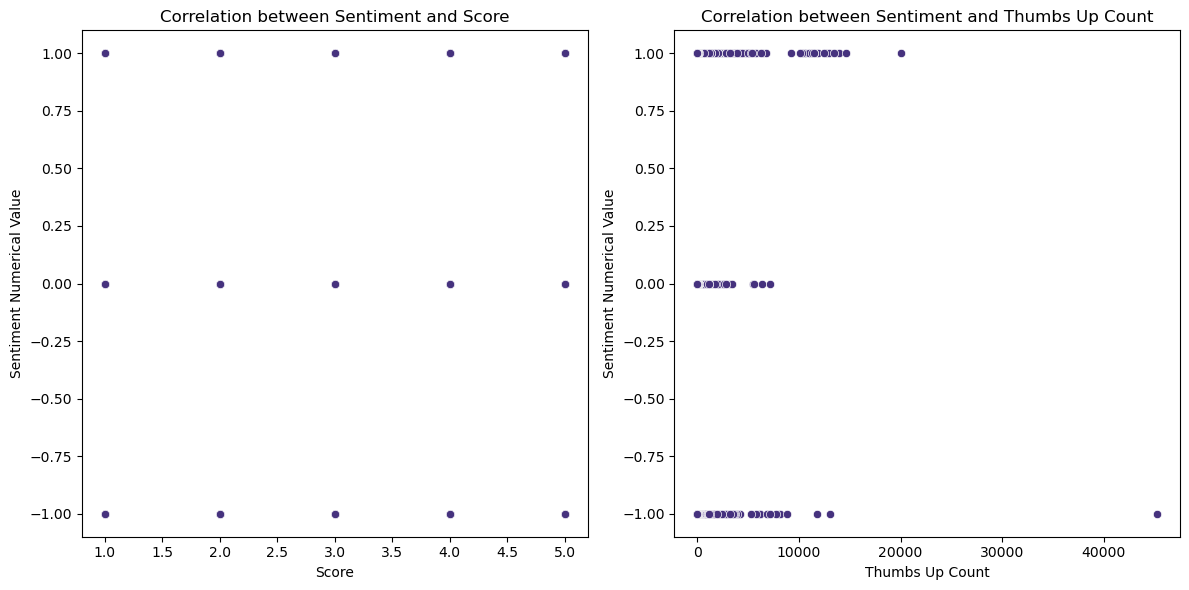

Correlation between Sentiment and Score: 0.40
Correlation between Sentiment and Thumbs Up Count: -0.00


In [77]:
# Map sentiment to numerical values (-1 for negative, 0 for neutral, 1 for positive)
sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
df['sentiment_numerical'] = df['sentiment'].map(sentiment_mapping)

# Calculate correlation between sentiment and score
correlation_score = df['sentiment_numerical'].corr(df['score'])

# Calculate correlation between sentiment and thumbsUpCount
correlation_thumbs_up = df['sentiment_numerical'].corr(df['thumbsUpCount'])

# Visualize the correlations
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='score', y='sentiment_numerical')
plt.title('Correlation between Sentiment and Score')
plt.xlabel('Score')
plt.ylabel('Sentiment Numerical Value')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='thumbsUpCount', y='sentiment_numerical')
plt.title('Correlation between Sentiment and Thumbs Up Count')
plt.xlabel('Thumbs Up Count')
plt.ylabel('Sentiment Numerical Value')

plt.tight_layout()
plt.show()

# Print the correlation coefficients
print(f"Correlation between Sentiment and Score: {correlation_score:.2f}")
print(f"Correlation between Sentiment and Thumbs Up Count: {correlation_thumbs_up:.2f}")

<img src="Photo/Logo Mobile Legends.png" width="300"  height="100" align=center>